In [1]:
import os
import ast
import random
import logging
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt

from collections import OrderedDict
from tqdm import tqdm_notebook as tqdm

import sys
sys.path.append('..')

In [2]:
def replacer(lines):

    lines = lines.replace(".", " . ")
    lines = lines.replace("?", " ? ")
    lines = lines.replace("!", " ! ")
    lines = lines.replace(")", " ) ")
    lines = lines.replace("(", " ( ")
    lines = lines.lower()
    return lines


In [3]:
with open("../food/text.txt") as ftext:
    reader = ftext.readlines()
    
with open("../food/lbls.txt") as ftext:
    leader = ftext.readlines()

FileNotFoundError: [Errno 2] No such file or directory: '../food/text.txt'

In [ ]:
doc, lbl = [], []

In [ ]:
for line in reader:
    line = replacer(line)
    doc.append(line.strip())

In [ ]:
for line in leader:
    itr = line.strip().split(', ')
    
    string = ''
    for itm in itr:
        string += "__label__{} ".format(itm)
    lbl.append(string)

In [ ]:
df = pd.DataFrame(columns=["label", "doc"])

In [ ]:
df["doc"] = doc
df["label"] = lbl

In [4]:
df.to_csv("../food/data.txt", sep=',', quotechar=' ', index=False, header=False)

NameError: name 'df' is not defined

In [5]:
a = [(6, 0), (6, 1), (1, 2), (0, 3), (1, 4), (0, 5)]

In [6]:
a = [(0,1), (0,2), (1,3), (1,4), (2,5), (2,6)]

In [7]:
b = [(30, 1), (30, 2), (2, 3), (1,3)]

In [8]:
G = nx.DiGraph()

In [9]:
G.add_edges_from(a)

In [3]:
G = nx.read_edgelist("../../hiercost/hiercost/data/clef/cat_hier.txt", create_using=nx.DiGraph, nodetype=int)

In [11]:
len(G.nodes())

97

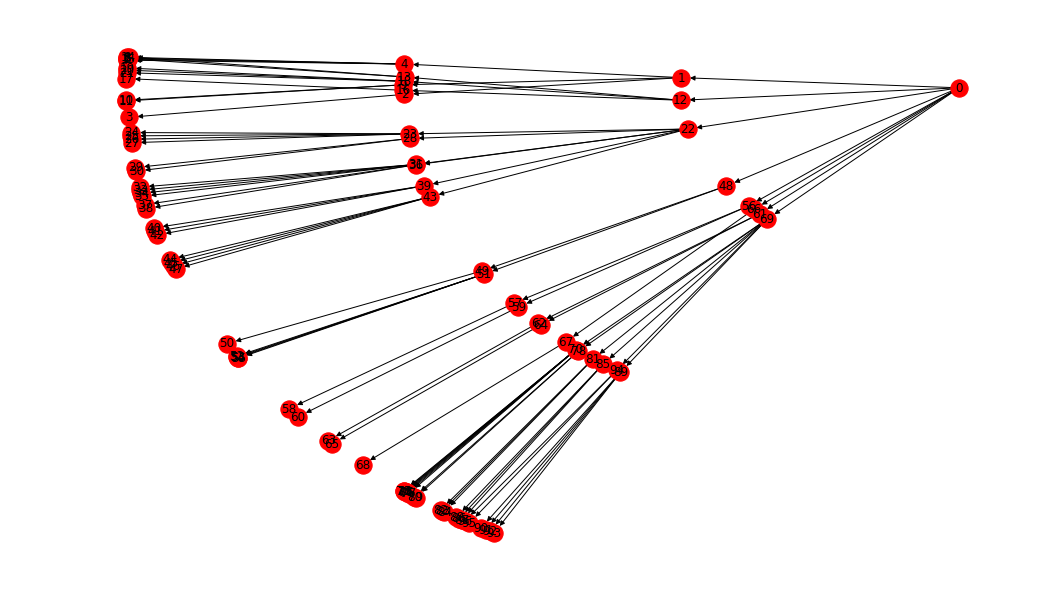

In [4]:
plt.figure(figsize=(14,8))
nx.draw_kamada_kawai(G, with_labels=True)

In [13]:
train_node_list = [n for n in G.nodes() if len(list(G.successors(n)))==0]

In [14]:
len(train_node_list)

63

In [6]:
top_level = []
temp = []
while len(train_node_list) > 0:
    pred = []
    for leaves in train_node_list:
        if len(list(G.predecessors(leaves)))>0:
            level_up = list(G.predecessors(leaves))
            for n in level_up:
                if n not in pred:
                    pred.append(n)
                parent = list(G.predecessors(n))
                children = list(G.successors(n))
        else:
            if leaves not in top_level:
                top_level.append(leaves)            
    train_node_list = pred
    temp.append(train_node_list)

for root in top_level:
    children = list(G.successors(root))

In [7]:
set_r = set(top_level)
internal_levels = []
for level in temp:
    new_l = set(level) - set_r
    if len(new_l) > 0:
        internal_levels.append(list(new_l))

In [8]:
p = np.zeros(3)

In [9]:
set_r

{0}

In [10]:
print(internal_levels)

[[64, 2, 67, 4, 70, 9, 13, 78, 16, 81, 18, 85, 23, 89, 28, 94, 31, 36, 39, 43, 49, 51, 57, 59, 62], [1, 66, 69, 12, 48, 22, 56, 61]]


In [ ]:
def non_leaf_update(parents, children):
    
    sum_pi = 0
    sum_c = 0
    
    len_cn = len(children)
    
    if len(parents) > 0:
            
        for p in parents:
            sum_pi+=w_dict[p]
            
        for c in children:
            sum_c+=w_dict[c]
            
    else:
        for c in children:
            sum_c+=w_dict[c]
            
    update_Wn = (sum_pi + sum_c)/(len_cn + 1)
    
    return update_Wn

In [49]:
h = nx.bfs_successors(G, 6, depth_limit=2)

In [45]:
list(G.predecessors(3))

[0]

In [10]:
list(G.predecessors(0))

[6]

In [11]:
f = nx.traversal.dfs_preorder_nodes(G, 6, 1)

In [12]:
list(f)

[6, 0, 1]

In [13]:
def get_root(graph):

    in_degree = nx.in_degree_centrality(graph)

    root = []

    min_v = min(in_degree.values())
    for k, v in in_degree.items():
        if v == min_v:
            root.append(k)

    return root

In [14]:
root = get_root(G)


In [15]:
u = {}
for r in root:
    c = nx.traversal.dfs_preorder_nodes(G, r, 1)
    if r not in u:
        u[r] = list(c)
        for i in u[r]:
            if i not in root:
                root.append(i)

In [16]:
u

{6: [6, 0, 1], 0: [0, 3, 5], 1: [1, 2, 4], 3: [3], 5: [5], 2: [2], 4: [4]}

In [7]:
shape = (1, 4)

In [143]:
y = nx.in_degree_centrality(G)

In [144]:
y

{0: 0.0,
 1: 0.008620689655172414,
 2: 0.017241379310344827,
 3: 0.008620689655172414,
 4: 0.008620689655172414,
 5: 0.008620689655172414,
 6: 0.0,
 7: 0.008620689655172414,
 8: 0.008620689655172414,
 9: 0.008620689655172414,
 10: 0.017241379310344827,
 11: 0.017241379310344827,
 12: 0.008620689655172414,
 13: 0.008620689655172414,
 14: 0.008620689655172414,
 15: 0.008620689655172414,
 16: 0.008620689655172414,
 17: 0.0,
 18: 0.008620689655172414,
 19: 0.008620689655172414,
 20: 0.008620689655172414,
 21: 0.008620689655172414,
 22: 0.017241379310344827,
 23: 0.008620689655172414,
 24: 0.008620689655172414,
 25: 0.008620689655172414,
 26: 0.008620689655172414,
 27: 0.008620689655172414,
 28: 0.008620689655172414,
 29: 0.008620689655172414,
 30: 0.07758620689655173,
 31: 0.017241379310344827,
 32: 0.034482758620689655,
 33: 0.02586206896551724,
 34: 0.008620689655172414,
 35: 0.008620689655172414,
 36: 0.008620689655172414,
 37: 0.008620689655172414,
 38: 0.008620689655172414,
 39: 0.008

In [19]:
root = []
min_v = min(y.values())
for k, v in y.items():
    if v == min_v:
        root.append(k)

In [20]:
w_dict = {}

In [12]:
for root_node in root:
    w = np.random.randn(*shape)
    w_dict[root_node] = w

for root_node in root:
    for child in G.successors(root_node):
        if child not in w_dict:
            noise = np.random.uniform(0.001, 0.005)
            w_dict[child] = w_dict[root_node] + noise
            root.append(child)

In [13]:
w_dict

{6: array([[ 0.30869536, -0.68444918, -1.80885204,  0.88864319]]),
 0: array([[ 0.3136149 , -0.67952964, -1.80393251,  0.89356273]]),
 1: array([[ 0.31062103, -0.68252351, -1.80692638,  0.89056885]]),
 2: array([[ 0.31266738, -0.68047716, -1.80488002,  0.89261521]]),
 3: array([[ 0.3110261 , -0.68211844, -1.80652131,  0.89097393]]),
 4: array([[ 0.31314948, -0.67999506, -1.80439793,  0.8930973 ]]),
 5: array([[ 0.31129505, -0.68184949, -1.80625235,  0.89124288]])}

In [14]:
for n in G.nodes():
    if len(list(G.successors(n))) == 0:
        print(n)

0
1
2
3
4
5


In [201]:
c = np.random.randn(2,3).fl

In [203]:
c.flatten().shape

(6,)

In [27]:
def BFS(s): 
    # applicable only for directed graphs
    visited = [0] * (len(G)) 
    traversal = []
    new_edges = []
    queue = [] 

    queue.append(s) 
    visited[s]+=1

    while queue: 

        s = queue.pop(0) 
        traversal.append(s)

        for i in G.neighbors(s): 
            queue.append(i) 
            visited[i] +=1
            if visited[i] != 1:
#                 new_edges.append((s, i+visited[i]+len(G)))
                new_edges.append((s, "{}-{}".format(s, i)))
            else:
                new_edges.append((s, i))
            
    return new_edges

In [28]:
new_edges = BFS(0)

In [29]:
r = nx.DiGraph()

In [30]:
r.add_edges_from(new_edges)

In [31]:
r.edges()

OutEdgeView([(0, 1), (0, 2), (1, 3), (2, '2-3')])

In [32]:
nx.is_tree(r)

True

In [34]:
import matplotlib.pyplot as plt

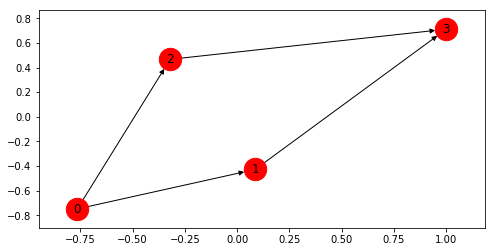

In [38]:
plt.figure(figsize=(8,4))
nx.draw_networkx(G, with_labels=True, node_size=500)